In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score
from keras.applications.inception_v3 import InceptionV3, preprocess_input

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download jessicali9530/celeba-dataset
! unzip celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [ ]:

! unzip celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [ ]:
DATA_PATH = 'img_align_celeba/img_align_celeba/'
ATTRIBUTE_PATH = 'list_attr_celeba.csv'
PARTITION_PATH = 'list_eval_partition.csv'

EXAMPLE_PIC = DATA_PATH + '000001.jpg'
IMG_WIDTH = 178
IMG_HEIGHT = 218

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 1000
TEST_SAMPLES = 1000

BATCH_SIZE = 16
NUM_EPOCHS = 20
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

In [ ]:
# list_attr_celeba.csv
attr_df = pd.read_csv(ATTRIBUTE_PATH, index_col='image_id')
attr_df.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [ ]:
attr_df.replace(to_replace=-1, value=0, inplace=True)
attr_df.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [ ]:
# Attributes
print('Attributes:')
for i, j in enumerate(attr_df.columns):
    print('    {:02d}: {}'.format(i,j))

Attributes:
    00: 5_o_Clock_Shadow
    01: Arched_Eyebrows
    02: Attractive
    03: Bags_Under_Eyes
    04: Bald
    05: Bangs
    06: Big_Lips
    07: Big_Nose
    08: Black_Hair
    09: Blond_Hair
    10: Blurry
    11: Brown_Hair
    12: Bushy_Eyebrows
    13: Chubby
    14: Double_Chin
    15: Eyeglasses
    16: Goatee
    17: Gray_Hair
    18: Heavy_Makeup
    19: High_Cheekbones
    20: Male
    21: Mouth_Slightly_Open
    22: Mustache
    23: Narrow_Eyes
    24: No_Beard
    25: Oval_Face
    26: Pale_Skin
    27: Pointy_Nose
    28: Receding_Hairline
    29: Rosy_Cheeks
    30: Sideburns
    31: Smiling
    32: Straight_Hair
    33: Wavy_Hair
    34: Wearing_Earrings
    35: Wearing_Hat
    36: Wearing_Lipstick
    37: Wearing_Necklace
    38: Wearing_Necktie
    39: Young


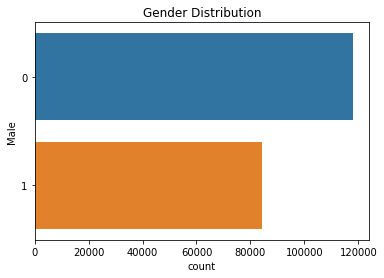

In [ ]:
# Gender distribution
plt.title('Gender Distribution')
sns.countplot(y = 'Male', data=attr_df)
plt.show()

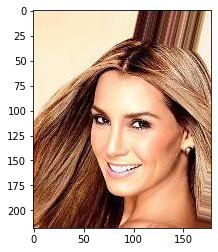

In [ ]:
# Plotting an example
img = load_img(EXAMPLE_PIC)

plt.imshow(img)
plt.show()

In [ ]:
# list_eval_partition.csv
parti_df = pd.read_csv(PARTITION_PATH, index_col='image_id')
parti_df.head()

,partition
image_id,
000001.jpg,0
000002.jpg,0
000003.jpg,0
000004.jpg,0
000005.jpg,0


In [ ]:
# Partitions
parti_df.value_counts()

partition
0            162770
2             19962
1             19867
dtype: int64

In [ ]:
# Joining csv
sampling_df = attr_df[['Male']].join(parti_df)
sampling_df.head()

,Male,partition
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,1,0
000004.jpg,0,0
000005.jpg,0,0


In [ ]:
# Sampling
def load_reshape_img(filename):
    img = load_img(filename)
    img_array = img_to_array(img)/255
    img_array = img_array.reshape((1,) + img_array.shape)
    return img_array
    

def sampling(partition, sample_size, sampling_df):
    parti_mask = sampling_df['partition'] == partition
    male_mask = sampling_df['Male'] == 1
    female_mask = sampling_df['Male'] == 0
    sampled_df = pd.concat([
        sampling_df[parti_mask & male_mask].sample(sample_size//2),
        sampling_df[parti_mask & female_mask].sample(sample_size//2)
    ])
    
    if partition != 2:
        x = np.array([load_reshape_img(DATA_PATH + filename) for filename in sampled_df.index])
        x = x.reshape(x.shape[0], 218, 178, 3)
        y = np_utils.to_categorical(sampled_df['Male'],2)
    else:
        x = []
        y = []
        for index, target in sampled_df.iterrows():
            im = cv2.imread(DATA_PATH + index) # return BGR
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0 # convert it to RGB for consistency
            im = np.expand_dims(im, axis =0)
            x.append(im)
            y.append(target['Male'])
            
    return x, y

In [ ]:
# Splitting
x_train, y_train = sampling(0, TRAINING_SAMPLES, sampling_df)
x_valid, y_valid = sampling(1, VALIDATION_SAMPLES, sampling_df)
x_test, y_test = sampling(2, TEST_SAMPLES, sampling_df)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(x_train, y_train,batch_size=BATCH_SIZE)

In [ ]:
# Model
model = Sequential()
model.add(Conv2D(16, (3,3), input_shape = INPUT_SHAPE, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.5))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.5))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.5))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.5))

model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 216, 176, 16)      448       
                                                                 
 batch_normalization_6 (Batc  (None, 216, 176, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 108, 88, 16)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 106, 86, 32)       4640      
                                                                 
 batch_normalization_7 (Batc  (None, 106, 86, 32)      128       
 hNormalization)                                                 
                                                      

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
checkpointer = ModelCheckpoint(filepath='model.h5', verbose=1, save_best_only=True)

In [ ]:
hist = model.fit(
    train_generator,
    validation_data = (x_valid, y_valid),
    steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE,
    epochs= 20,
    callbacks=[checkpointer],
    verbose=1
)

Epoch 1/20
625/625 [==============================] - ETA: 0s - loss: 0.5269 - accuracy: 0.7417
Epoch 1: val_loss improved from 0.53469 to 0.46645, saving model to model.h5
625/625 [==============================] - 80s 129ms/step - loss: 0.5269 - accuracy: 0.7417 - val_loss: 0.4664 - val_accuracy: 0.8010
Epoch 2/20
625/625 [==============================] - ETA: 0s - loss: 0.4990 - accuracy: 0.7614
Epoch 2: val_loss improved from 0.46645 to 0.45034, saving model to model.h5
625/625 [==============================] - 77s 123ms/step - loss: 0.4990 - accuracy: 0.7614 - val_loss: 0.4503 - val_accuracy: 0.8090
Epoch 3/20
625/625 [==============================] - ETA: 0s - loss: 0.4658 - accuracy: 0.7857
Epoch 3: val_loss did not improve from 0.45034
625/625 [==============================] - 76s 121ms/step - loss: 0.4658 - accuracy: 0.7857 - val_loss: 0.7459 - val_accuracy: 0.6200
Epoch 4/20
625/625 [==============================] - ETA: 0s - loss: 0.4486 - accuracy: 0.7966
Epoch 4: val_

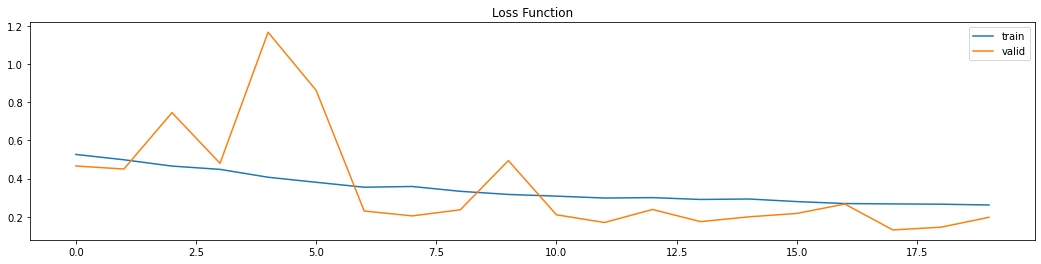

In [ ]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

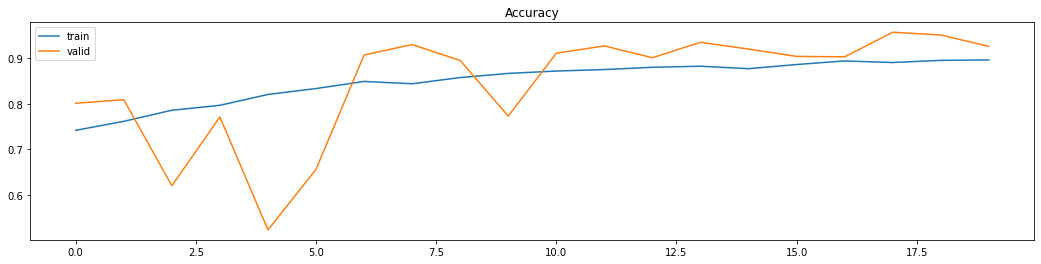

In [ ]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [ ]:
# Model Evaluation
model.load_weights('model.h5')
predictions = [np.argmax(model.predict(image)) for image in x_test]
accuracy = 100 * np.sum(np.array(predictions)==y_test) / len(predictions)
f1 = f1_score(y_test, predictions)

print('Accuracy: {:.4f}'.format(accuracy))
print('F1 score: {:.4f}'.format(f1))

Accuracy: 95.5000
F1 score: 0.9552


In [ ]:
#dictionary to name the prediction
gender_target = {0: 'Female'
                , 1: 'Male'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    # credits to stassl :)
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
    

def display_result(filename, prediction, target):
    gender = 'Male'
    gender_icon = "https://png.pngtree.com/png-clipart/20190705/original/pngtree-man-avatar-icon-professional-man-character-png-image_4356027.jpg"
        
    if prediction[1] <= 0.5:
        gender_icon = "https://png.pngtree.com/png-clipart/20190614/original/pngtree-female-avatar-vector-icon-png-image_3725439.jpg"
        gender = 'Female'
            
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 480px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">Prediction: {}</h3>
            <p style="margin-left: 50px; margin-top: -6px; font-size: 12px">{} probability</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Real gender: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender_icon
               , gender
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , gender_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [ ]:
def gender_prediction(filename):

      im = cv2.imread(filename)
      im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
      im = np.expand_dims(im, axis =0)
      
      # prediction
      result = model.predict(im)
      prediction = np.argmax(result)
      
      return result


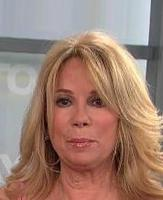


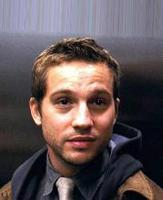


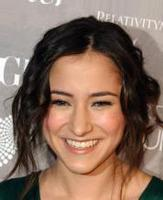


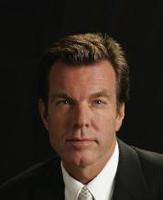


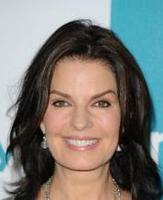


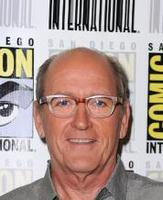


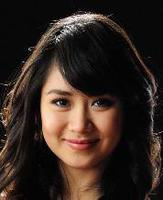


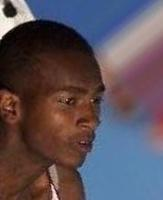


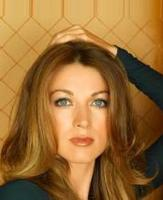


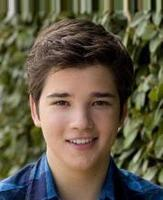

In [ ]:
from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline
#select random images of the test partition
df_to_test = sampling_df[(sampling_df['partition'] == 2)].sample(10)

for index, target in df_to_test.iterrows():
    result = gender_prediction(DATA_PATH + index)
    
    #display result
    display_result(DATA_PATH + index, result[0], target['Male'])